### dot product attention

In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from src.models import TAMCaD, TAMCaD_T
from src.training import train_model, train_test_split
from src.eval import plot_contemporaneous_relationships, plot_all_contemporaneous_relationships, plot_heatmaps
from tqdm.notebook import trange, tqdm
from sklearn.manifold import TSNE

In [2]:
dataset_name = 'synthetic_N-16_T-2000_K-5'
dataset = torch.load(f'../data_generation/{dataset_name}.pt')
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

model_variations = {
    'TAMCaD_default': {'model_type': TAMCaD, 'gamma': 0.005, 'hidden_dim': 24, 'weight_sharing': True, 'epochs': 700, 'dropout': 0.2},
    'TAMCaD_T': {'model_type': TAMCaD_T, 'gamma': 0.005, 'hidden_dim': 24, 'weight_sharing': True, 'epochs': 700, 'dropout': 0.2},
}
params = {
    'experiment_name': 'dotproduct',
    'lr': 1e-3,
    'weight_decay': 1e-8,
    'test_size': 0.3,
    'kernel_size': 2,
    'n_blocks': 2,
    'n_layers': 2,
    'use_positional_embedding': True
}


all_results = {}

for id, model_params in model_variations.items():
    print('Process', id)
    all_results[id] = []
    for i in range(1):
        data_subset = {
            'name': dataset_name, 
            'data': dataset['data'][i:i+1], 
            'data_noise_adjusted': dataset['data_noise_adjusted'][i:i+1], 
            'ground_truth': dataset['ground_truth'][i]
        }
        all_results[id].append(train_model(
                experiment_run=id,
                dataset=data_subset,
                **model_params,
                **params
            ))

{'name': 'synthetic_N-16_T-2000_K-5', 'data': torch.Size([10, 16, 2000]), 'data_noise_adjusted': torch.Size([10, 16, 2000]), 'ground_truth': torch.Size([10, 16, 16])}
Process TAMCaD_default


[train] loss=0.25,noise=0.11,AUROC=0.94 [test] loss=0.24,noise=0.08,AUROC=0.94: 100%|█| 700/700 [00:21<00:00, 32.30it/s


Process TAMCaD_T


[train] loss=0.25,noise=0.11,AUROC=0.93 [test] loss=0.25,noise=0.09,AUROC=0.93: 100%|█| 700/700 [00:18<00:00, 38.46it/s


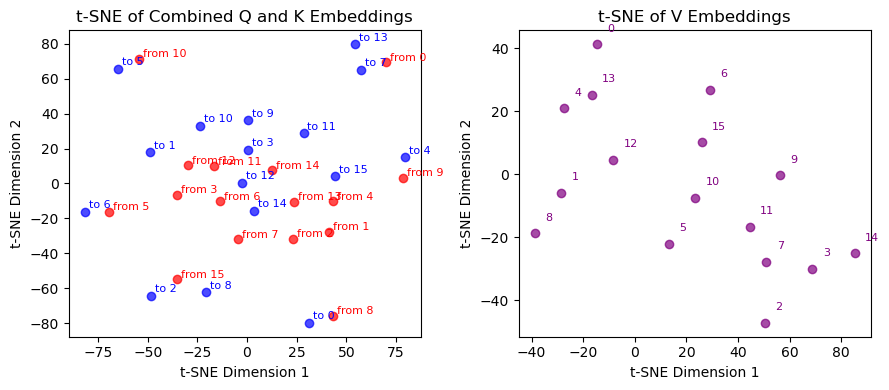

In [26]:

result = all_results['TAMCaD_T'][0]
# Assuming result['test_artifacts']['q'], result['test_artifacts']['v'], result['test_artifacts']['k'] are available
# Convert tensors to numpy arrays (if they are not already)
q_embeddings = result['test_artifacts']['q'].numpy()  # Replace with .detach().cpu().numpy() if they are PyTorch tensors
v_embeddings = result['test_artifacts']['v'].numpy()
k_embeddings = result['test_artifacts']['k'].numpy()

# Assuming the q_embeddings, v_embeddings, k_embeddings are available as numpy arrays
n_var = q_embeddings.shape[0]  # Number of variables
offset1, offset2 = 2, 4

combined_qk = np.concatenate([q_embeddings, k_embeddings], axis=0)

# t-SNE transformation
tsne_qk = TSNE(n_components=2, random_state=0, perplexity=10).fit_transform(combined_qk)
tsne_v = TSNE(n_components=2, random_state=0, perplexity=3).fit_transform(v_embeddings)

# Plotting
plt.figure(figsize=(9, 4))

# Plot for combined Q and K embeddings
plt.subplot(1, 2, 1)
for i in range(n_var):
    # Q embeddings
    plt.scatter(tsne_qk[i, 0], tsne_qk[i, 1], alpha=0.7, color='blue')
    plt.text(tsne_qk[i, 0]+offset, tsne_qk[i, 1]+offset, f"to {i}", color='blue', fontsize=8)
    
    # K embeddings
    plt.scatter(tsne_qk[n_var + i, 0], tsne_qk[n_var + i, 1]+1, alpha=0.7, color='red')
    plt.text(tsne_qk[n_var + i, 0]+offset, tsne_qk[n_var + i, 1]+offset, f"from {i}", color='red', fontsize=8)
plt.title('t-SNE of Combined Q and K Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Plot for V embeddings
plt.subplot(1, 2, 2)
for i in range(n_var):
    plt.scatter(tsne_v[i, 0], tsne_v[i, 1], alpha=0.7, color='purple')
    plt.text(tsne_v[i, 0]+offset2, tsne_v[i, 1]+offset2, f"{i}", color='purple', fontsize=8)
plt.title('t-SNE of V Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()


